# Inspect Files

This file contains code to load G3 files produced by ``g3_packager``, and view some of their data.

To run this Jupyter notebook on the CCAT Control Computer, see [``HOWTORUN.md``](./HOWTORUN.md).

## Setup

In [1]:
import numpy as np
import os
import g3utils as ut
import matplotlib.pyplot as plt
from spt3g import core

In [2]:
control_computer_g3_dir = "/media/player1/blast2020fc1/blasttng_g3"

# file produced by g3_packager to analyze
filename = os.path.join(control_computer_g3_dir, "testing/roach1_pass3.g3")

### File Content Overview

Which frames are present in the g3 file?

In [3]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(ut.FrameCounter)
pipe.Run()


Calibration
PipelineInfo
Scan (x117)
EndProcessing


### File Content Full Dump

Print all the contents of the file.

In [4]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(core.Dump)
pipe.Run()

Frame (Calibration) [
"cal_lamp_data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 3000)
"target_sweeps" (spt3g.core.G3TimestreamMap) => Timestreams from 1143 detectors
"x_shifts" (spt3g.core.G3MapDouble) => 381 elements
"y_shifts" (spt3g.core.G3MapDouble) => 381 elements
]
Frame (PipelineInfo) [
"11-Apr-2025:18:23:59.896407000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
"11-Apr-2025:20:16:34.001127000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
]
Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"el" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lat" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lon" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"time" (spt3g.core.G3Time) => 11-Apr-2025:18:23:59.895659000
]
Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples

### Scan Frames

Get some sample scan frames that can be inspected more closely

In [5]:
first_scan_grabber = ut.FirstFrameGrabber(core.G3FrameType.Scan)
last_scan_grabber = ut.LastFrameGrabber(core.G3FrameType.Scan)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(first_scan_grabber)
pipe.Add(last_scan_grabber)
pipe.Run()

# store the frames for analysis
first_scan_frame = first_scan_grabber.first_frame
last_scan_frame = last_scan_grabber.last_frame

print("\nFirst Scan Frame: ", first_scan_frame)
print("\nLast Scan Frame: ", last_scan_frame)

Found the last frame with type: Scan!
The frame is now stored in <g3utils.LastFrameGrabber object at 0x7faaec7a3b80>'s last_frame attribute.

First Scan Frame:  Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"el" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lat" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lon" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"time" (spt3g.core.G3Time) => 11-Apr-2025:18:23:59.895659000
]

Last Scan Frame:  Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 935 samples at 473.1 Hz
"az" (spt3g.core.G3Timestream) => 935 samples at 473.1 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 935)
"el" (spt3g.core.G3Timestream) => 935 samples at 473.1 Hz
"lat" (spt3g.core.G3Timestream) => 935 samples at 473.1 Hz
"lon" (spt3g.core.G3Timestream) => 935 samples at 473.1 Hz
"time" (s

### Calibration Frame

Get a calibration frame and see what it contains.

In [6]:
calframe_grabber = ut.FirstFrameGrabber(core.G3FrameType.Calibration)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(calframe_grabber)
pipe.Run()

cal_frame = calframe_grabber.first_frame

print("\nCalibration Frame: ", cal_frame)


Calibration Frame:  Frame (Calibration) [
"cal_lamp_data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 3000)
"target_sweeps" (spt3g.core.G3TimestreamMap) => Timestreams from 1143 detectors
"x_shifts" (spt3g.core.G3MapDouble) => 381 elements
"y_shifts" (spt3g.core.G3MapDouble) => 381 elements
]


#### Detector Layout

Plot the detector layout stored in the calibration frame

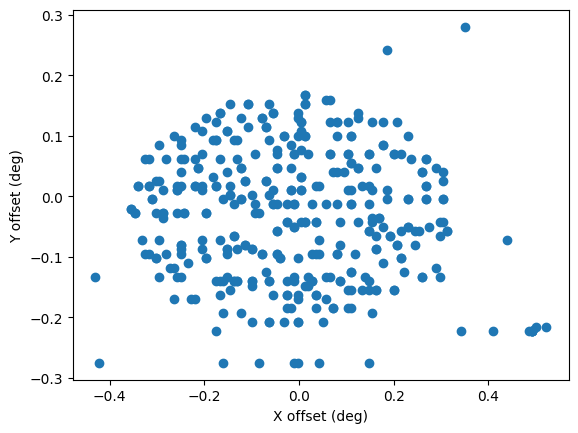

In [7]:
x_vals = np.asarray(cal_frame["x_shifts"].values()) / core.G3Units.deg
y_vals = np.asarray(cal_frame["y_shifts"].values()) / core.G3Units.deg
plt.scatter(x_vals, y_vals)
plt.xlabel("X offset (deg)")
plt.ylabel("Y offset (deg)")
plt.show()

### Plot RA/Dec

Plot the boresight path in celestical coordinates for the data in this file.

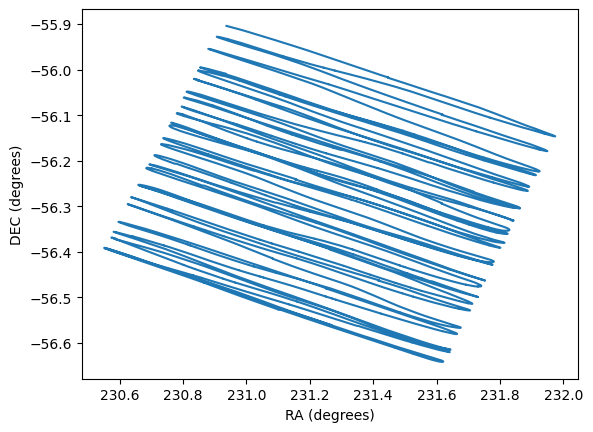

In [8]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(ut.add_radec_so3g)
pipe.Add(ut.PlotRaDec)
pipe.Run()

### Plot DF For A Sample KID

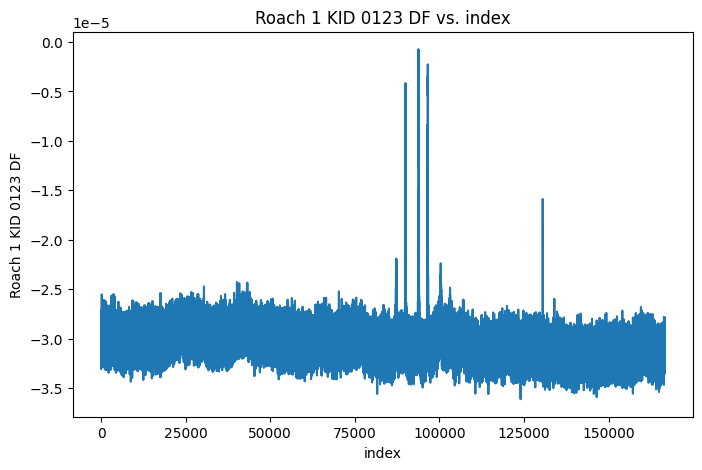

In [9]:
pipe = core.G3Pipeline()

def kid_df_ctremoved_getter(kid: str):
    def get_selected_kid_df(frame):
        kid_key = f"roach1_{kid}"
        super_ts = frame["df_ctremoved"]
        kid_idx = int(np.where(np.array(super_ts.names) == kid_key)[0][0])
        return np.array(super_ts.data[kid_idx])
    return get_selected_kid_df

kid_to_plot = "0123"
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(ut.AddSingleKidDF, roach_id=1, kid=kid_to_plot)
pipe.Add(ut.TimeStreamPlotter,
         label=f"Roach 1 KID {kid_to_plot} DF",
         ts_key=f"roach1_{kid_to_plot}_DF",
         subplots_args={"figsize": (8, 5)})
pipe.Run()

### Plot Single KID Maps

Plot some sample KID maps, using non-normalized DF

In [10]:
# center of the sky map
ra0 = 231.15 * core.G3Units.deg
dec0 = -56.2 * core.G3Units.deg

# map dimensions
xlen = 1.4 * core.G3Units.deg
ylen = 0.9 * core.G3Units.deg

# pixel resolution
res = 1 * core.G3Units.arcmin

In [ ]:
# instantiate binners
binners = [
    ut.SingleMapBinner(kid=f"roach1_0{i:03}", timestreams="df", ra0=ra0, dec0=dec0, xlen=xlen, ylen=ylen, res=res)
    for i in range(100, 106)  # sample kid ids
]

# create the pipeline
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(ut.add_radec_so3g)
pipe.Add(ut.AddScanDF, roach_id=1)
for binner in binners:
    pipe.Add(binner)
pipe.Run()

fig, axs = plt.subplots(2, 3, figsize=(12, 6.5), sharex='all', sharey='all')
fig.suptitle("Roach 1 Pass 3, Single KID Sample Maps"
            "\nNon-normalized DF")

for binner, ax in zip(binners, axs.flat):
    binner.plot(ax=ax)
plt.show()